# SnAr Benchmark Visualization

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pareto_front import NSGAII, DomainWrapper
from snar_experiment_visualization import PlotExperiments
from summit.benchmarks import SnarBenchmark
from summit.utils.dataset import DataSet
from summit.utils.multiobjective import hypervolume, pareto_efficient
from summit.strategies import Random
from summit.strategies import Chimera, MultitoSingleObjective

from pymoo.model.problem import Problem
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.factory import get_termination


from neptune.sessions import Session, HostedNeptuneBackend
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())  #load neptune api token

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from hiplot import Experiment
import plotly
import plotly.express as px

import numpy as np
from math import log
import numpy as np
import json
from pandas.plotting import parallel_coordinates
import pandas as pd

## Pareto Front

### Random
Here, I am trying to used random search to determine the pareto front. I really do not think that works well though.

In [ ]:
def determine_pareto_front(n_points=5000, random_seed=100):
    exp = SnarBenchmark()
    rand = Random(exp.domain, 
                  random_state=np.random.RandomState(random_seed))
    experiments = rand.suggest_experiments(n_points)
    exp.run_experiments(experiments)
    return exp

In [ ]:
exp = determine_pareto_front(n_points=int(2e4))

In [ ]:
fig, ax = exp.pareto_plot()

In [ ]:
fig, ax = exp.pareto_plot()
names = [r'Space Time Yield ($kg \; m^{-3} h^{-1}$)', 'E-factor']
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_ylim(9, 11)
ax.tick_params(direction='in')

### NSGAII Platypus

Here, I am using NSGA to determine the pareto front.

In [ ]:
exp = SnarBenchmark()
exp.reset()
optimizer = NSGAII(exp)
r = optimizer.optimize(iterations=int(1e4))

In [ ]:
fig, ax = exp.pareto_plot()
names = [r'Space Time Yield ($kg \; m^{-3} h^{-1}$)', 'E-factor']
ax.set_xlabel(names[0], fontsize=12)
ax.set_ylabel(names[1], fontsize=12)
_ = ax.set_ylim(9.3, 10.0)

In [ ]:
print("Size of the pareto front:", len(exp.pareto_data))

In [ ]:
data = exp.pareto_data[['sty', 'e_factor']].to_numpy()
data[:, 0] = -1.0*data[:, 0]
means = np.mean(data, axis=0)
stds = np.std(data, axis=0)
data_std = (data-means)/stds

plt.scatter(data_std[:,0], data_std[:,1])
HvI.hypervolume(data_std, ref=[1.5,2])

## NSGA-II Pymoo

In [ ]:
# Set up problem
exp = SnarBenchmark()
exp.reset()
problem = DomainWrapper(exp)

# Set up optimisation
generations = 100
pop_size = 100
optimizer = NSGA2(pop_size=pop_size)
termination = get_termination("n_gen", generations)

# Run optimisation
res = minimize(
    problem, optimizer, termination, seed=1, verbose=True
)

In [ ]:
exp.data.to_csv('pareto_front_snar.csv')

In [ ]:
fig, ax = plt.subplots()
exp.pareto_plot(ax=ax)
ax.set_xlim (2000, 1.2e4)
ax.set_ylim(9.2, 11)
names = [r'Space Time Yield ($kg \; m^{-3} h^{-1}$)', 'E-factor']
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.tick_params(direction='in')
fig.savefig('figures/pareto_front_snar.png', dpi=300)
fig.savefig('figures/pareto_front_snar.svg')

In [ ]:
pareto_data = exp.pareto_data[['sty', 'e_factor']].to_numpy()
pareto_data[:, 0] *= -1.0 #Convert to minimization
nadir = np.max(pareto_data, axis=0)
print("Reference point:", nadir)
HvI.hypervolume(pareto_data, nadir)

## Visualize Sensitivity

In [ ]:
ds = DataSet.read_csv('pareto_front_snar.csv')
data_std_arr = ds.standardize()
data = pd.DataFrame(data_std_arr, columns=ds.data_columns)
# parallel_coordinates(data.iloc[9000:int(1e4)], 'strategy', color=("#dcdfe6"), alpha=0.05)

In [ ]:
data_log = ds[ds.data_columns].copy()
data_log[('sty', 'DATA')]= data_log['sty'].apply(log)
data_log[('e_factor', 'DATA')]= data_log['e_factor'].apply(log)
data_std_arr = data_log.standardize()
data_log = pd.DataFrame(data_std_arr, columns=ds.data_columns)

In [ ]:
Experiment.from_iterable(data_log.to_dict(orient='records')).display()

In [ ]:
data_log_new = data_log.copy()
data_log_new['strategy'] = 'NSGAII'
parallel_coordinates(data_log_new[data_log['e_factor']<-0.5], 
                     "strategy", 
                     color=("#dcdfe6"), 
                     alpha=0.05,
                     xticks=[r'$\tau$', 'Equiv 1', 'Conc 2', 'Temperature', 'STY'])

## Multiobjective Transforms

### Chimera

Chimera is a scalarisation technique created by Hase et al. 

In [ ]:
def plot_chimera(hierarchy, ax):
    # Setup 
    exp = SnarBenchmark()
    chim = Chimera(exp.domain, hierarchy)
    r = Random(exp.domain,
               random_state=np.random.RandomState(100))

    # Get data and run chimera transformation
    experiments = r.suggest_experiments(50)
    results =exp.run_experiments(experiments)
    inputs, outputs = chim.transform_inputs_outputs(results)

    # Plot
    x, y, z = results['sty'], results['e_factor'], outputs['chimera']
    ax.scatter(x, y, z, 
               s=100, marker='o')
    base = np.min(z)
    for xi, yi, zi in zip(x, y, z):        
        line=art3d.Line3D(*zip((xi, yi, base), (xi, yi, zi)), markevery=(1, 1))
        ax.add_line(line)
    ax.set_xlabel('sty')
    ax.set_ylabel('E-factor')
    ax.set_zlabel('Chimera')
    ax.view_init(10, 60)
    return ax

In [ ]:
# Compare different tolerances
hierarchies = [{'sty': {'hierarchy': 0, 'tolerance': 1}, 
                'e_factor': {'hierarchy': 1, 'tolerance': 1}},
               
               {'sty': {'hierarchy': 0, 'tolerance': 0.5}, 
                'e_factor': {'hierarchy': 1, 'tolerance': 0.5}},
               
               {'sty': {'hierarchy': 0, 'tolerance': 1.0}, 
                'e_factor': {'hierarchy': 1, 'tolerance': 0.5}},
               
               {'sty': {'hierarchy': 0, 'tolerance': 0.5}, 
                'e_factor': {'hierarchy': 1, 'tolerance': 1.0}}
              ]

fig = plt.figure(figsize=(10,10))
for i, hierarchy in enumerate(hierarchies):
    # First plot
    ax = fig.add_subplot(2,2, i+1, projection='3d')
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    plot_chimera(hierarchy, ax)
    ax.set_title(f"STY_tol={hierarchy['sty']['tolerance']}, E-factor_tol={hierarchy['e_factor']['tolerance']}")
    fig.tight_layout()
    fig.savefig('figures/chimera_comparison.png', dpi=300)

Note that chimera turns everyhting into a minimization problem. Tolerance is probably not the best descriptor of how this works; a better term would be weighting. Higher tolerance values mean you weight an objective more. The relative weighting is what matters. (1,1) and (0.5,0.5) are identical. However, decreasing the weighting of E-factor with minimal change in STY results in STY being weighted much more heavily.

### Custom ASF

In [ ]:
def plot_custom_asf(ax):
    # Setup 
    exp = SnarBenchmark()
    asf = MultitoSingleObjective(exp.domain,expression='-sty/1e4+e_factor/100',maximize=False)
    r = Random(exp.domain,
               random_state=np.random.RandomState(100))

    # Get data and run chimera transformation
    experiments = r.suggest_experiments(50)
    results =exp.run_experiments(experiments)
    inputs, outputs = asf.transform_inputs_outputs(results)

    # Plot
    x, y, z = results['sty'], results['e_factor'], outputs['scalar_objective']
    ax.scatter(x, y, z,
               s=100, marker='o')
    base = np.min(z)
    for xi, yi, zi in zip(x, y, z):        
        line=art3d.Line3D(*zip((xi, yi, base), (xi, yi, zi)), markevery=(1, 1))
        ax.add_line(line)
    ax.set_xlabel('sty')
    ax.set_ylabel('E-factor')
    ax.set_zlabel('Custom ASF')
    ax.view_init(10, 60)
    return ax

fig =plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
plot_custom_asf(ax)
fig.tight_layout()
fig.savefig('figures/custom_asf.png', dpi=300)

### Hypervolume Improvement

In [ ]:
from summit.utils.multiobjective import hypervolume, pareto_efficient

In [ ]:
def plot_hvi(ax):
    # Setup 
    exp = SnarBenchmark()
    tsemo = TSEMO2(exp.domain)
    r = Random(exp.domain,
               random_state=np.random.RandomState(100))
    
    # Get data and run chimera transformation
    experiments = r.suggest_experiments(50)
    results = exp.run_experiments(experiments)
    inputs, outputs = tsemo.transform.transform_inputs_outputs(results)
    
    # Extra points for evaluation
    new_experiments = r.suggest_experiments(50)
    samples = exp.run_experiments(new_experiments)
    
    #Make STY negative for minimization
    y = outputs.to_numpy()
    y[:, 0] = -1.0*y[:,0]
    samples_inputs, samples_outputs = tsemo.transform.transform_inputs_outputs(samples)
    y_samples = samples_outputs.to_numpy()
    y_samples[:,0] = -1.0*y_samples[:,0]
    
    # Initial pareto front
    y_front, _ = pareto_efficient(y, maximize=False)           
    
    #Reference point
    r = np.max(y_front, axis=0)+0.01*(np.max(y_front, axis=0)-np.min(y_front,axis=0))
    
    # Base hypervolume
    hv_base = HvI.hypervolume(y_front, r)
    
    # Hypervolume Improvement
    hypervolumes = []
    hvi = []
    for sample in y_samples:
        sample = np.atleast_2d(sample)
        y_new = np.append(y_front,sample, axis=0)
        y_front_new, _ = pareto_efficient(y_new, maximize=False)
        hv = HvI.hypervolume(y_front_new, r)
        hypervolumes.append(hv)
        hvi.append(hv-hv_base)

    # Plot
    x, y, z = y_samples[:,0], y_samples[:,1], hvi
    ax.scatter(x, y, z, 
               s=100, marker='o')
    for xi, yi, zi in zip(x, y, z):        
        line=art3d.Line3D(*zip((xi, yi, 0), (xi, yi, zi)), markevery=(1, 1))
        ax.add_line(line)
    ax.set_xlabel('sty')
    ax.set_ylabel('E-factor')
    ax.set_zlabel('Hypervolume Improvement')
    ax.view_init(0, 60)
    return ax, hypervolumes, hvi

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax, hv, hvi = plot_hvi(ax)
fig.savefig('hypervolume')

## Snar Experiments V1

In [ ]:
from snar_experiment_visualization import PlotExperiments
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())  #load neptune api token
import pandas as pd

New experiments start with SUM-716

In [ ]:
pe = PlotExperiments('sustainable-processes/summit',
                     experiment_ids=[f'SUM-{id}' for id in range(716,1053)])

In [ ]:
# View mean iterations to reach threshold
iterations_table = pe.iterations_to_threshold(sty_threshold=6e3, e_factor_threshold=15.0)
iterations_table.to_csv('data/snar_iterations_threshold_SUM716-1053.csv')
iterations_table

Making the table for the paper.

In [ ]:
#Read in CSV
df = pd.read_csv('data/snar_iterations_threshold_SUM716-1053.csv')

# Commbine columns
df = df.dropna(subset=['mean_iterations'])
iterations=[]
transforms = []
for i, row in df.iterrows():
    iterations.append(f"{round(row['mean_iterations'],0)}$\pm${round(row['std_iterations'],2)}")
    transform_text = row['transform_name']
    chimera_params = f" (STY tol.={row['sty_tolerance']}, E-factor tol.={row['e_factor_tolerance']})"
    transform_text += chimera_params if row['transform_name'] == "Chimera" else ""
    transforms.append(transform_text)
df['iterations'] = iterations
df['transform'] = transforms
df = df.replace('SOBO', 'GPyOpt')

#Formatting 
df = df.fillna('-')
df = df.sort_values(['strategy_name','iterations', 'transform'])
df = df[['strategy_name','transform', 'iterations']]
df = df.rename(columns=lambda s: s.replace('_', ' ').title())
df = df.rename(columns={'Sty Tolerance': "STY Tolerance"})

df

In [ ]:
latex_str = df.to_latex(index=False, escape=False, bold_rows=True)
print(latex_str)

## Snar Experiments V2

In [135]:
# IDs of Neptune Experiments
ids  = [f'SUM-{i}' for i in range(4166,4266)] + \
       [f'SUM-{i}' for i in range(3916,4016)] + \
       [f'SUM-{i}' for i in range(2600,3262)] + \
        [f'SUM-{i}' for i in range(4026,4029)]

# Gather experiments from Neptune. This can be slow.
results = PlotExperiments("sustainable-processes/summit",
                          trajectory_length=50,
                          experiment_ids=ids,
                          tag=['snar_experiment'],
                          state=['succeeded'])
# Save to csv 
results.to_csv("data/snar_results.csv")

Let's make an interactive plot of the hypervolume trajectories, for exploration sake. 

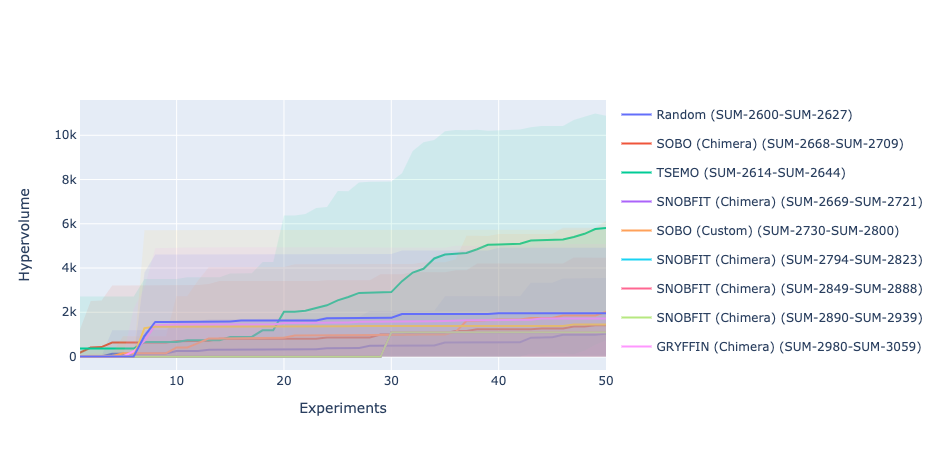

In [137]:
fig = results.plot_hv_trajectories(min_terminal_hv_avg=1000, 
                                   include_experiment_ids=True,plot_type='plotly')

You can double click on an item in the legend to solo it. I'm going to increase the threshold for the publication figure, so I only include the top three strategies.

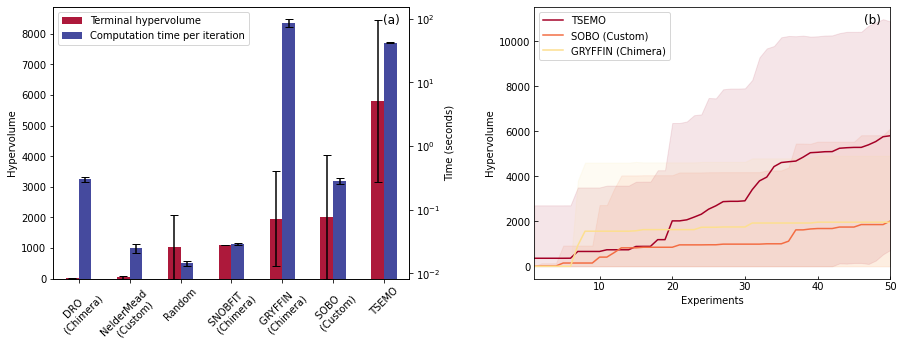

In [138]:
# Create figure
fig  = plt.figure(figsize=(15, 5))
fig.subplots_adjust(wspace=0.35,)

# Hypervolume, Time bar plot
ax = fig.add_subplot(1, 2, 1)
results.time_hv_bar_plot(ax)
ax.text(0.95,0.95, '(a)',
         horizontalalignment='center', 
         verticalalignment='center',
         transform = ax.transAxes,
         fontdict={'fontsize': 12})

# Hypervolume trajectory plot
ax = fig.add_subplot(1, 2, 2)
ax, legend = results.plot_hv_trajectories(min_terminal_hv_avg=1900, 
                                          include_experiment_ids=False,plot_type='matplotlib',
                                          ax=ax)
ax.legend(loc="upper left")
ax.text(0.95,0.95, '(b)',
         horizontalalignment='center', 
         verticalalignment='center',
         transform = ax.transAxes,
         fontdict={'fontsize': 12})

# Save figure
fig.savefig("figures/snar_hv_time_tradeoff.png", dpi=300, bbox_inches='tight')

# TODO: print out caption with transform settings.

Above is a figure to examine the pros/cons of different optimisation strategies. What you see is that the Bayesian optimisation strategies perform best, finding the most optimal points in the alotted number of iterations. However, that comes at the price of 3 orders of magnitude greater computation cost. Furthermore, the experiments were run on a HPC with up to 32 threads dedicated for each strategy, so our experience is that the runtime increases by ~10x on consumer hardware.  The longer computation time is likely acceptable inc the case of TSEMO given the signifcant improvement in performance, but it might not make since in the case of GRYFFIN or the SOBO (GpyOpt) strategies..

(<Figure size 720x360 with 2 Axes>, <AxesSubplot:title={'center':'TSEMO'}>)

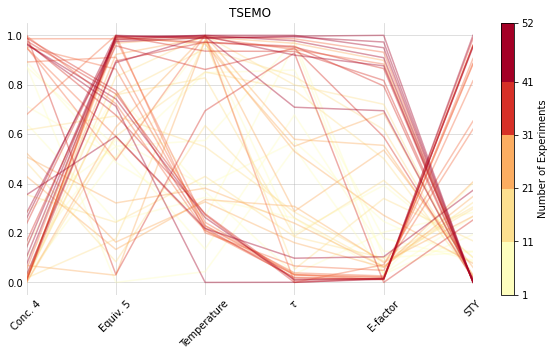

In [139]:
results.parallel_plot("SUM-2688")

I made the above parallel plot to show how the decision variables correspond with the objectives. However, I don't think it's clean enough for a publication.

Below, are the pareto plots for the run from each combination of strategy and transform that had the highest terminal hypervolume.

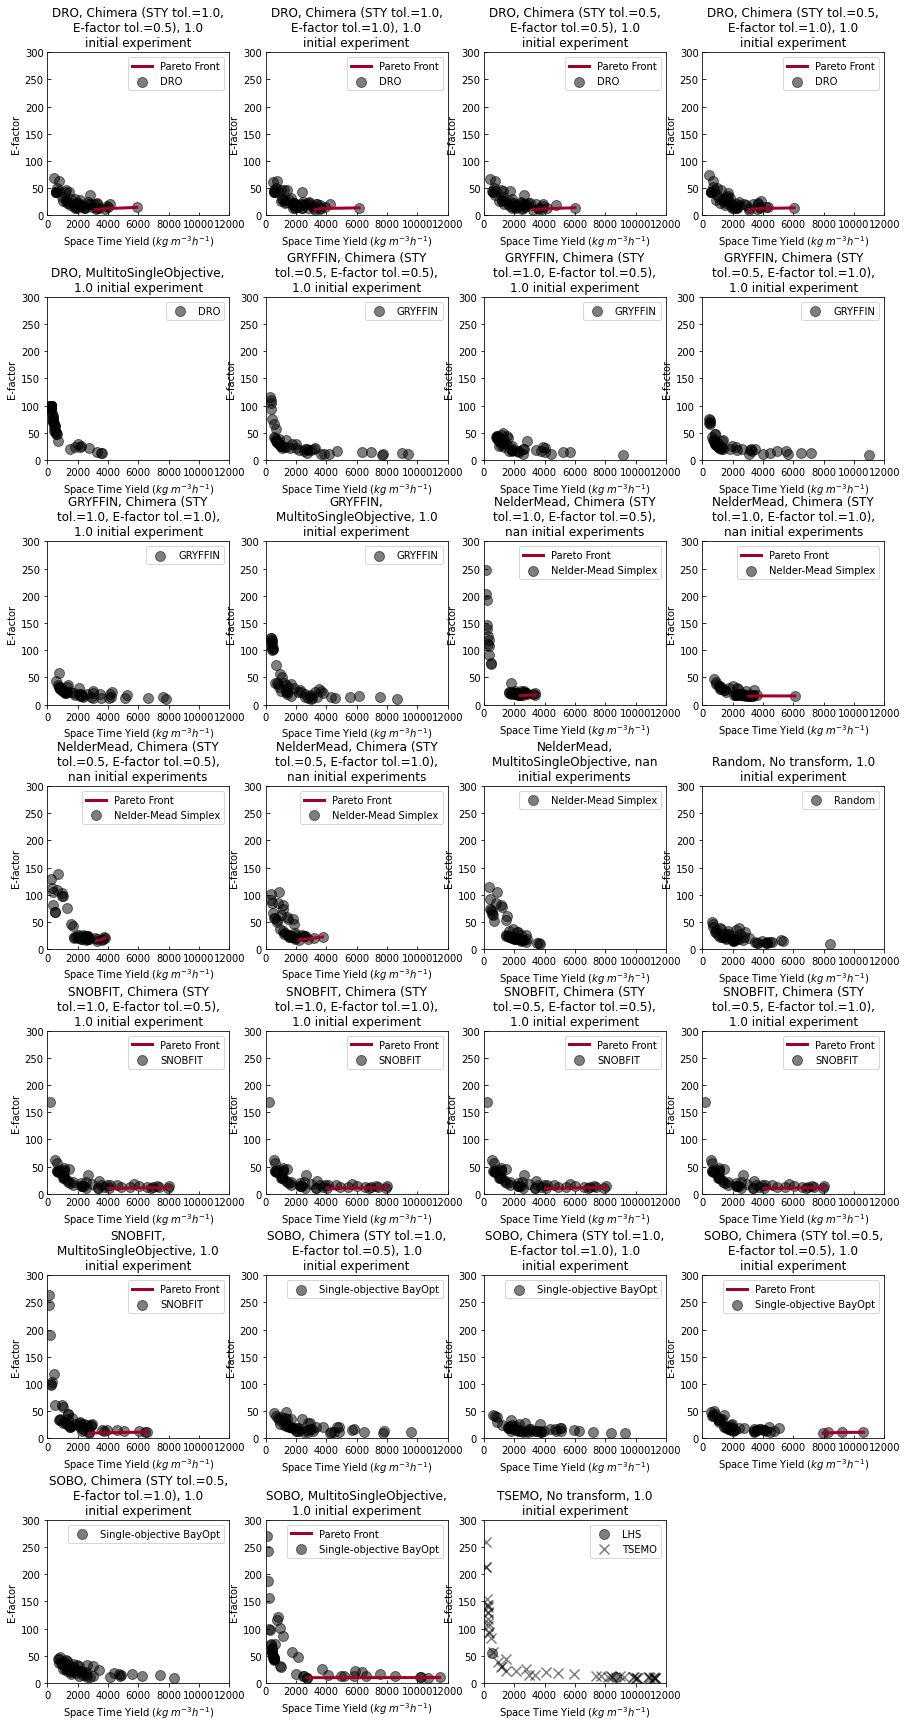

In [158]:
fig = results.best_pareto_grid(ncols=4, figsize=(15, 30))
fig.savefig('figures/snar_pareto_fronts.png', dpi=300, bbox_inches='tight')

In the publication, I would like to have one figure that gently introduces multiobjective optimisation and hypervolume.  

In [156]:
COLORS = [
    (165, 0, 38),
    (215, 48, 39),
    (244, 109, 67),
    (253, 174, 97),
    (254, 224, 144),
    (255, 255, 191),
    (224, 243, 248),
    (171, 217, 233),
    (116, 173, 209),
    (69, 117, 180),
    (49, 54, 149),
]
COLORS = np.array(COLORS) / 256
CMAP = mpl.colors.ListedColormap(COLORS)

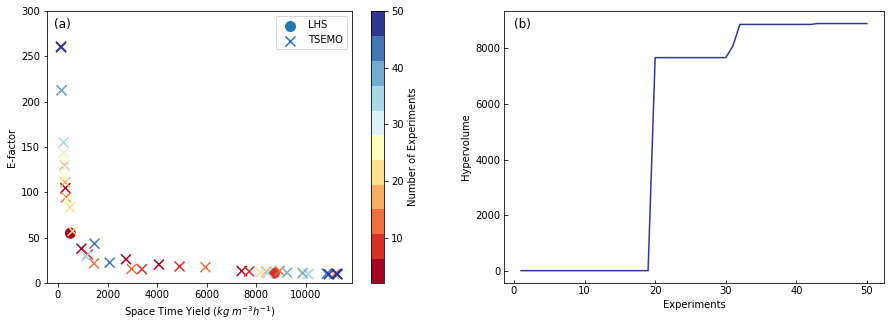

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Find run with maximum terminal hypervolume
df = results.df
max_index = df["terminal_hypervolume"].argmax()
experiment_id = df.iloc[max_index]['experiment_id']
r = results.runners[experiment_id]

# Pareto plot
ax, im = r.experiment.pareto_plot(colorbar=True, ax=axes[0])
fig.colorbar(im, ax=ax, label='Number of Experiments')
ax.set_ylim(0, 300)
ax.set_xlabel(r"Space Time Yield ($kg \; m^{-3} h^{-1}$)")
ax.set_ylabel("E-factor")
axes[0].text(0.05,0.95, '(a)',
             horizontalalignment='center', 
             verticalalignment='center',
             transform = axes[0].transAxes,
             fontdict={'fontsize': 12})

# Hypervolume plot
data = r.experiment.data[['sty', 'e_factor']].to_numpy()
data[:, 0] *= -1  # make it a minimzation problem
hv_trajectory = np.zeros([results.trajectory_length])
for i in range(results.trajectory_length):
    y_front, _ = pareto_efficient(data[0 : i + 1, :], maximize=False)
    hv_trajectory[i] = hypervolume(y_front, ref=[-2957, 10.7])
t = np.arange(1, results.trajectory_length + 1)
axes[1].plot(t, hv_trajectory, c=COLORS[-1])
axes[1].set_xlabel('Experiments')
axes[1].set_ylabel('Hypervolume')
axes[1].tick_params(direction='in')
axes[1].text(0.05,0.95, '(b)',
             horizontalalignment='center', 
             verticalalignment='center',
             transform = axes[1].transAxes,
             fontdict={'fontsize': 12})

# Save plot
fig.savefig('figures/snar_tsemo_pareto_hv.png', dpi=300)

Finally, I want to make make a table that summarises the all the combinations of strategies and multiobjective transforms.

In [144]:
df = results.df.copy()
df["computation_t"] = df["computation_t"]/results.trajectory_length
# Group repeats
df = df.drop(columns=["expression", "maximize", "noise_level"])
by=[
    "strategy_name",
    "transform_name",
    "sty_tolerance",
    "e_factor_tolerance",
    "batch_size",
    "num_initial_experiments",
]
grouped_df = df.groupby(
    by=by,
    dropna=False,
).head(20).groupby(by, dropna=False)

# Take mean and standard deviation
stds = grouped_df.std().round(0)
counts = grouped_df.count()['experiment_id']
grouped_df = grouped_df.mean().round(0)

# Count the number of repeats
for col in ["terminal_hypervolume", 'computation_t']:
    grouped_df[col] = [f"{m}$\pm${s}"
                       for m, s in zip(grouped_df[col].values,
                                       stds[col].values)
                     ]
grouped_df['Repeats'] = counts

# Rename column headers and clean up index
grouped_df.rename(columns={"terminal_hypervolume": "Terminal hypervolume",
                           "computation_t": "Time per iter. (s)"},
                  inplace=True)
grouped_df.index.rename(["Strategy", "Transform","STY tolerance",
                         "E-factor tolerance", "batch_size", "num_initial_experiments"],
                        inplace=True)
grouped_df.index = grouped_df.index.droplevel(["batch_size", "num_initial_experiments"])

#Replace Nas
grouped_df = grouped_df.fillna('-').round(0)

# Disiplay
grouped_df

Terminal hypervolume  \
Strategy   Transform              STY tolerance E-factor tolerance                        
DRO        Chimera                0.5           0.5                       10.0$\pm$29.0   
                                                1.0                         2.0$\pm$7.0   
                                  1.0           0.5                         0.0$\pm$2.0   
                                                1.0                        7.0$\pm$29.0   
           MultitoSingleObjective NaN           NaN                         0.0$\pm$0.0   
GRYFFIN    Chimera                0.5           0.5                    669.0$\pm$1132.0   
                                                1.0                   1449.0$\pm$2243.0   
                                  1.0           0.5                   1715.0$\pm$1766.0   
                                                1.0                   1959.0$\pm$1545.0   
           MultitoSingleObjective NaN           NaN                    528.0$\pm$1048.0   
NelderMead Chimera                0.5           0.5                         0.0$\pm$0.0   
                                                1.0                         0.0$\pm$0.0   
                                  1.0           0.5                         0.0$\pm$0.0   
                                                1.0                         0.0$\pm$0.0   
           MultitoSingleObjective NaN           NaN                      43.0$\pm$108.0   
Random     Transform              NaN           NaN                   1032.0$\pm$1315.0   
SNOBFIT    Chimera                0.5           0.5                      1095.0$\pm$0.0   
                                                1.0                      1095.0$\pm$0.0   
                                  1.0           0.5                      1095.0$\pm$0.0   
                                                1.0                      1095.0$\pm$0.0   
           MultitoSingleObjective NaN           NaN                         0.0$\pm$0.0   
SOBO       Chimera                0.5           0.5                    634.0$\pm$1049.0   
                                                1.0                     593.0$\pm$876.0   
                                  1.0           0.5                   1414.0$\pm$1599.0   
                                                1.0                    786.0$\pm$1325.0   
           MultitoSingleObjective NaN           NaN                   2013.0$\pm$2155.0   
TSEMO      Transform              NaN           NaN                   5803.0$\pm$2659.0   

                                                                   Time per iter. (s)  \
Strategy   Transform              STY tolerance E-factor tolerance                      
DRO        Chimera                0.5           0.5                       0.0$\pm$0.0   
                                                1.0                       0.0$\pm$0.0   
                                  1.0           0.5                       0.0$\pm$0.0   
                                                1.0                       0.0$\pm$0.0   
           MultitoSingleObjective NaN           NaN                       0.0$\pm$0.0   
GRYFFIN    Chimera                0.5           0.5                     79.0$\pm$11.0   
                                                1.0                     78.0$\pm$11.0   
                                  1.0           0.5                    106.0$\pm$19.0   
                                                1.0                     87.0$\pm$12.0   
           MultitoSingleObjective NaN           NaN                     89.0$\pm$10.0   
NelderMead Chimera                0.5           0.5                       0.0$\pm$0.0   
                                                1.0                       0.0$\pm$0.0   
                                  1.0           0.5                       0.0$\pm$0.0   
                                                1.0                       0.0$\pm$0.0   
   

In [150]:
print("Number of experiments for this benchmark:", len(grouped_df)*20*50)

Number of experiments for this benchmark: 27000


In [145]:
# Convert the table to Latex format
latex_str = grouped_df.to_latex(index=True, escape=False, bold_rows=False)
latex_str = latex_str.replace("MultitoSingleObjective", "Custom")
latex_str = latex_str.replace('NaN', '-')
print(latex_str)

\begin{tabular}{llllllr}
\toprule
      &           &     &     & Terminal hypervolume & Time per iter. (s) &  Repeats \\
Strategy & Transform & STY tolerance & E-factor tolerance &                      &                    &          \\
\midrule
DRO & Chimera & 0.5 & 0.5 &        10.0$\pm$29.0 &        0.0$\pm$0.0 &       20 \\
      &           &     & 1.0 &          2.0$\pm$7.0 &        0.0$\pm$0.0 &       20 \\
      &           & 1.0 & 0.5 &          0.0$\pm$2.0 &        0.0$\pm$0.0 &       20 \\
      &           &     & 1.0 &         7.0$\pm$29.0 &        0.0$\pm$0.0 &       20 \\
      & Custom & - & - &          0.0$\pm$0.0 &        0.0$\pm$0.0 &       20 \\
GRYFFIN & Chimera & 0.5 & 0.5 &     669.0$\pm$1132.0 &      79.0$\pm$11.0 &       20 \\
      &           &     & 1.0 &    1449.0$\pm$2243.0 &      78.0$\pm$11.0 &       20 \\
      &           & 1.0 & 0.5 &    1715.0$\pm$1766.0 &     106.0$\pm$19.0 &       20 \\
      &           &     & 1.0 &    1959.0$\pm$1545.0 &      

**2020/08/01**: Generally, the Bayesian optimisation strategies perform best, but require longer comptuation time.  

**From sometime before**
These results are fascinating!  These are my observations:

- The Bayesian optimisation strategies perform best. Surprisingly SNOBFIT is actually quite slow.
- TSEMO is better at optimising the hypervolume (i.e. the quality of the pareto front), while Gryffin offers better performance in fewer iterations. In other words, TSEMO gives better quality but requires more iterations, while Gryffin gives decent quality in few iterations. Also, TSEMO has much more consistent performance but not by much.
- The last table shows that there is still a lot of room for improvement in terms of consistency. Only 3/20 runs of the best Chimera+Gryffin combo reach the threshold, while only 6/20 runs of TSEMO reach the threshold. The rest of the strategies do not ever reach the the threshold! Even, random peforms better!